`antman` conda environment

In [4]:
from pygenomeviz import GenomeViz
import Bio.SeqIO as SeqIO
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import h5py
import pysam
import re
import os
import subprocess
import seaborn as sns
import sys
from PIL import Image
from tqdm import tqdm
sys.path.append('../')
from transcriptomics import * 
from plotting import * 
import warnings 
from concurrent.futures import ProcessPoolExecutor
from scipy.stats import ranksums
warnings.filterwarnings('ignore')

# Set pandas display options
pd.set_option('display.max_columns', None)

# Load genome
genome_fasta_path = '../genome/Obir.assembly.v5.4.fasta'
genome_seq = SeqIO.to_dict(SeqIO.parse(genome_fasta_path, "fasta"))

# Load transcriptome
tr = load_transcriptome_object("../transcriptome/biroi_transcriptome.pkl")

# Load or_db
or_db = pd.read_excel('../ORs/OR List.xlsx') 
or_db.loc[or_db.gene_name.isin(['Or5-9E198', 'Or5-9E200', 'Or5-9E201']), 'tandem_array'] = 35

white_plotting()
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

Initializing transcriptomics package
Initializing plotting package


## Plot coverage of a tandem array 

In [5]:
def get_coverage_rRNA_depleted(tissue, orientation, chrom, start, end): 
    base_path = '../first_of_pair_strand_coverage_chrom_h5'
    # Check that orientation is fwd or rev 
    assert orientation in ['fwd', 'rev'], "Orientation must be 'fwd' or 'rev'"
    # Replace fwd and rev with forward and reverse 
    orientation = 'forward' if orientation == 'fwd' else 'reverse'
    # Get the file path
    file_path = f"{base_path}/{tissue}_renamed_{orientation}_strand_coverage.h5"

    # Reading data
    with h5py.File(file_path, 'r') as f:
        chr_data = f[chrom][:]
    
    # Checks 
    assert 0 <= start < len(chr_data), "Start index is out of range"
    assert 0 < end <= len(chr_data), "End index is out of range"
    assert start < end, "Start must be less than end"

    # Return the coverage values for the specified range
    return chr_data[start:end]


In [6]:
def get_coverage_polyA_female(sample, orientation, chrom, start, end): 
    base_path = '../JL20240124_FemaleRNAseq_first_of_pair_strand_coverage_chrom_h5'
    # Check that orientation is fwd or rev 
    assert orientation in ['fwd', 'rev'], "Orientation must be 'fwd' or 'rev'"
    # Replace fwd and rev with forward and reverse 
    orientation = 'forward' if orientation == 'fwd' else 'reverse'
    # Get the file path
    file_path = f"{base_path}/{sample}_Aligned.sortedByCoord.out_{orientation}_strand_coverage.h5"

    # Reading data
    with h5py.File(file_path, 'r') as f:
        chr_data = f[chrom][:]
    
    # Checks 
    assert 0 <= start < len(chr_data), "Start index is out of range"
    assert 0 < end <= len(chr_data), "End index is out of range"
    assert start < end, "Start must be less than end"

    # Return the coverage values for the specified range
    return chr_data[start:end]

T79: Chr1:17883604-17944013


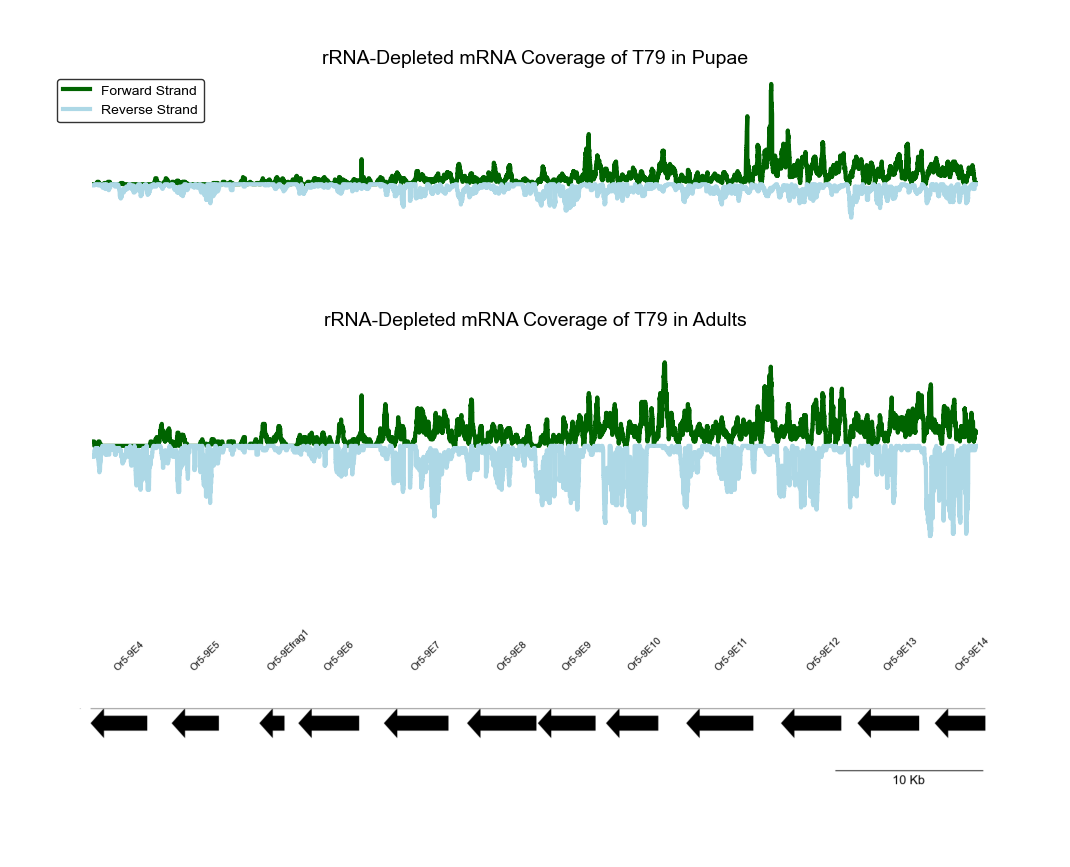

In [7]:
# Tandem Array Info
TA = 79
ta_genes = or_db[or_db['tandem_array'] == TA]['gene_name'].values
ta_chr = tr.get_gene(ta_genes[0]).chromosome

# Get gene bounds
ta_gene_bounds = [tr.get_gene(gene).get_transcript_longest_cds().get_bounds() for gene in ta_genes]
ta_start, ta_end = min([bounds[0] for bounds in ta_gene_bounds]), max([bounds[1] for bounds in ta_gene_bounds])
print(f"T{TA}: {ta_chr}:{ta_start}-{ta_end}")

# Specify Tisues 
#tissues = ['Eggs_S1', 'YoungLarvae_S2', '4thInstarLarvae_S3', 'Prepupae_S4', 'Pupae_S5', 'Adults_S6']
tissues = ['Pupae_S5', 'Adults_S6']

fig, axs = plt.subplots(len(tissues)+1, 1, figsize=(10, 8))
for i, tissue in enumerate(tissues):
    # Get Coverage
    fwd_coverage = get_coverage_rRNA_depleted(tissue, 'fwd', ta_chr, ta_start, ta_end)
    rev_coverage = get_coverage_rRNA_depleted(tissue, 'rev', ta_chr, ta_start, ta_end)

    # Plot Coverage
    ylim = max(max(fwd_coverage), max(rev_coverage)) + 10
    axs[i].plot(fwd_coverage, color='darkgreen', label='Forward Strand', linewidth=3)
    axs[i].plot(-np.array(rev_coverage), color='lightblue', label='Reverse Strand', linewidth=3)
    axs[i].set_title(f"rRNA-Depleted mRNA Coverage of T{TA} in {tissue.split('_')[0]}", fontsize=14)
    axs[i].set_ylabel('')
    axs[i].set_ylim(-ylim, ylim)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[0].legend(loc='upper left')
    for spine in axs[i].spines.values():
        spine.set_visible(False)

# Gene Annotations using GenomeViz
gv = GenomeViz(track_align_type="center", theme="light")
gv.set_scale_bar(ymargin=0.5)

# Create Feature Track
track = gv.add_feature_track(ta_chr, (int(ta_start), int(ta_end)), labelsize=0)

# Add Gene Models
for gene_name in ta_genes:
    gene = tr.get_gene(gene_name)
    transcript = gene.get_transcript_longest_cds()
    bounds = transcript.get_bounds()
    strand = 1 if transcript.strand == '+' else -1
    track.add_feature(
        int(bounds[0]), int(bounds[1]),
        strand,
        plotstyle='arrow',
        fc='black', 
        ec='black', 
        arrow_shaft_ratio=0.5,
        label=gene_name, 
    )

# Render GenomeViz as an Image
output_file = "../results/genome_viz.png"
gv.savefig(output_file)

# Display GenomeViz on Second Subplot
img = Image.open(output_file)
axs[len(tissues)].imshow(img)
axs[len(tissues)].axis('off')

# Finalize and Show
plt.tight_layout()
plt.show()

## Plot rRNA and regular mRNA sequencing coverage across TA 

T79: Chr1:17883604-17944013


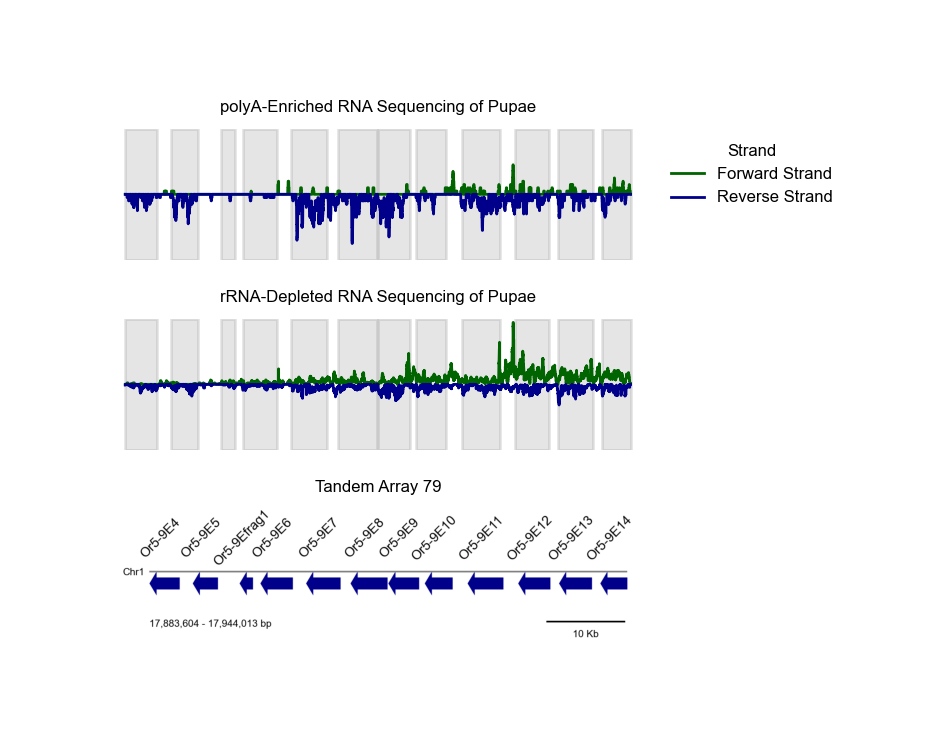

In [8]:
# Tandem Array Info
TA = 79
ta_genes = or_db[or_db['tandem_array'] == TA]['gene_name'].values
ta_chr = tr.get_gene(ta_genes[0]).chromosome

# Get gene bounds
ta_gene_bounds = [tr.get_gene(gene).get_transcript_longest_cds().get_bounds() for gene in ta_genes]
ta_start, ta_end = min([bounds[0] for bounds in ta_gene_bounds]), max([bounds[1] for bounds in ta_gene_bounds])
print(f"T{TA}: {ta_chr}:{ta_start}-{ta_end}")

fig, axs = plt.subplots(3, 1, figsize=(4, 3), height_ratios=[0.3, 0.3, 0.3], dpi=200)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
fontsize=6 
plt.subplots_adjust(hspace=0.1)

# Plot coverage of mRNA sequencing of female pupae 
sample = 'F1'
fwd_coverage = get_coverage_polyA_female(sample, 'fwd', ta_chr, ta_start, ta_end)
rev_coverage = get_coverage_polyA_female(sample, 'rev', ta_chr, ta_start, ta_end)
axs[0].plot(np.arange(ta_start, ta_end), fwd_coverage, color='darkgreen', label='Forward Strand', linewidth=1)
axs[0].plot(np.arange(ta_start, ta_end), -np.array(rev_coverage), color='darkblue', label='Reverse Strand', linewidth=1)
for ta_gene_bound in ta_gene_bounds: 
    axs[0].axvspan(ta_gene_bound[0], ta_gene_bound[1], color='grey', alpha=0.2)
axs[0].set_title(f"polyA-Enriched RNA Sequencing of Pupae", fontsize=fontsize)
axs[0].set_ylabel('')
ylim = max(max(fwd_coverage), max(rev_coverage)) + 5
axs[0].set_ylim(-ylim, ylim)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].legend(loc='upper left', fontsize=6, bbox_to_anchor=(1, 1), frameon=False, title='Strand', title_fontsize=6) 
axs[0].axis('off')

# Plot coverage of mRNA sequencing of pupae using rRNA depleted data 
tissue = 'Pupae_S5'
fwd_coverage = get_coverage_rRNA_depleted(tissue, 'fwd', ta_chr, ta_start, ta_end)
rev_coverage = get_coverage_rRNA_depleted(tissue, 'rev', ta_chr, ta_start, ta_end)
ylim = max(max(fwd_coverage), max(rev_coverage)) + 5
axs[1].plot(np.arange(ta_start, ta_end), fwd_coverage, color='darkgreen', label='Forward Strand', linewidth=1)
axs[1].plot(np.arange(ta_start, ta_end), -np.array(rev_coverage), color='darkblue', label='Reverse Strand', linewidth=1)
# Make grey bars where the gene bounds are 
for ta_gene_bound in ta_gene_bounds: 
    axs[1].axvspan(ta_gene_bound[0], ta_gene_bound[1], color='grey', alpha=0.2)
axs[1].set_title(f"rRNA-Depleted RNA Sequencing of Pupae", fontsize=6)
axs[1].set_ylabel('')
axs[1].set_ylim(-ylim, ylim)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].axis('off')


# Gene Annotations using GenomeViz
gv = GenomeViz(track_align_type="center", theme="light", fig_width=4, fig_track_height=0.4)
gv.set_scale_bar(ymargin=0.5, labelsize=6)

# Create Feature Track
track = gv.add_feature_track(ta_chr, (int(ta_start), int(ta_end)), labelsize=6)
track.add_sublabel(size=6, ymargin=1)

# Add Gene Models
for gene_name in ta_genes:
    gene = tr.get_gene(gene_name)
    transcript = gene.get_transcript_longest_cds()
    bounds = transcript.get_bounds()
    strand = 1 if transcript.strand == '+' else -1
    track.add_feature(
        int(bounds[0]), int(bounds[1]),
        strand,
        plotstyle='arrow',
        fc='darkblue', 
        ec='darkblue', 
        arrow_shaft_ratio=0.5,
        label=gene_name, 
        text_kws={'color': 'black', 
                  'rotation': 45, 
                  'vpos': 'top', 
                  'hpos': 'center', 
                  'size':8}
    )

# Render GenomeViz as an Image
output_file = "../results/genome_viz.png"
gv.savefig(output_file, dpi=300, pad_inches=0)

# Display GenomeViz on Second Subplot
img = Image.open(output_file)
axs[2].imshow(img)
axs[2].axis('off')
axs[2].set_title(f'Tandem Array {TA}', fontsize=6)

# Finalize and Show
plt.tight_layout()


#plt.savefig(f"../figures/t79-example.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

plt.show()


T79: Chr1:17883604-17944013


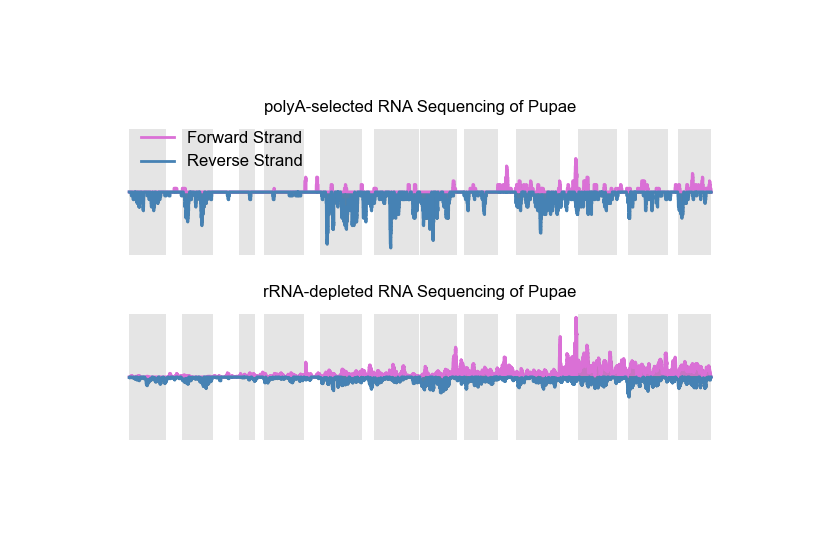

In [20]:
# Tandem Array Info
TA = 79
ta_genes = or_db[or_db['tandem_array'] == TA]['gene_name'].values
ta_chr = tr.get_gene(ta_genes[0]).chromosome

# Get gene bounds
ta_gene_bounds = [tr.get_gene(gene).get_transcript_longest_cds().get_bounds() for gene in ta_genes]
ta_start, ta_end = min([bounds[0] for bounds in ta_gene_bounds]), max([bounds[1] for bounds in ta_gene_bounds])
print(f"T{TA}: {ta_chr}:{ta_start}-{ta_end}")

fig, axs = plt.subplots(2, 1, figsize=(3.5, 2), dpi=200)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

# Plot coverage of mRNA sequencing of female pupae 
sample = 'F1'
fwd_coverage = get_coverage_polyA_female(sample, 'fwd', ta_chr, ta_start, ta_end)
rev_coverage = get_coverage_polyA_female(sample, 'rev', ta_chr, ta_start, ta_end)
# Plot coverage of mRNA sequencing of pupae using rRNA depleted data, filling in the space between the plot and the x-axis
axs[0].plot(np.arange(ta_start, ta_end), fwd_coverage, color='orchid', label='Forward Strand', linewidth=1)
axs[0].fill_between(np.arange(ta_start, ta_end), fwd_coverage, color='orchid', alpha=1)
axs[0].plot(np.arange(ta_start, ta_end), -np.array(rev_coverage), color='steelblue', label='Reverse Strand', linewidth=1)
axs[0].fill_between(np.arange(ta_start, ta_end), -np.array(rev_coverage), color='steelblue', alpha=1)
for ta_gene_bound in ta_gene_bounds: 
    axs[0].axvspan(ta_gene_bound[0], ta_gene_bound[1], color='grey', alpha=0.2, lw=0) 
axs[0].set_title(f"polyA-selected RNA Sequencing of Pupae", fontsize=6)
axs[0].set_ylabel('')
ylim = max(max(fwd_coverage), max(rev_coverage)) + 2
axs[0].set_ylim(-ylim, ylim)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].legend(loc='upper left', fontsize=6, bbox_to_anchor=(0.04, 1.1), frameon=False) 
axs[0].axis('off')

# Plot coverage of mRNA sequencing of pupae using rRNA depleted data 
tissue = 'Pupae_S5'
fwd_coverage = get_coverage_rRNA_depleted(tissue, 'fwd', ta_chr, ta_start, ta_end)
rev_coverage = get_coverage_rRNA_depleted(tissue, 'rev', ta_chr, ta_start, ta_end)
ylim = max(max(fwd_coverage), max(rev_coverage)) + 5
axs[1].plot(np.arange(ta_start, ta_end), fwd_coverage, color='orchid', label='Forward Strand', linewidth=1)
axs[1].fill_between(np.arange(ta_start, ta_end), fwd_coverage, color='orchid', alpha=1)
axs[1].plot(np.arange(ta_start, ta_end), -np.array(rev_coverage), color='steelblue', label='Reverse Strand', linewidth=1)
axs[1].fill_between(np.arange(ta_start, ta_end), -np.array(rev_coverage), color='steelblue', alpha=1)
# Make grey bars where the gene bounds are 
for ta_gene_bound in ta_gene_bounds: 
    axs[1].axvspan(ta_gene_bound[0], ta_gene_bound[1], color='grey', alpha=0.2, lw=0)
axs[1].set_title(f"rRNA-depleted RNA Sequencing of Pupae", fontsize=6)
axs[1].set_ylabel('')
axs[1].set_ylim(-ylim, ylim)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].axis('off')

# Finalize and Show
plt.tight_layout()
plt.savefig(f"../figures/t79-rRNA-and-polyA-coverage.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)
plt.show()
